# Base line code에 그래프 생성 코드 추가

 #For Leaning Curve 라고 적힌 세 부분 복사해서 코드에 붙여넣어 사용하시면 됩니다 

# Import requirements

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 6.5 MB 40.6 MB/s 
     |████████████████████████████████| 596 kB 57.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

# 1. Preprocess

In [3]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [6]:
!ls

sample_data	 sentiment.dev.1    sentiment.train.1
sentiment.dev.0  sentiment.train.0  test_no_label.csv


In [7]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


In [8]:
train_pos[:10]

['101 6581 2833 1012 102',
 '101 21688 8013 2326 1012 102',
 '101 2027 2036 2031 3679 19247 1998 3256 6949 2029 2003 2428 2204 1012 102',
 '101 2009 1005 1055 1037 2204 15174 2098 7570 22974 2063 1012 102',
 '101 1996 3095 2003 5379 1012 102',
 '101 2204 3347 2833 1012 102',
 '101 2204 2326 1012 102',
 '101 11350 1997 2154 2003 25628 1998 7167 1997 19247 1012 102',
 '101 2307 2173 2005 6265 2030 3347 27962 1998 5404 1012 102',
 '101 1996 2047 2846 3504 6429 1012 102']

In [9]:
print(len(train_pos))
print(len(train_neg))
print(len(dev_pos))
print(len(dev_neg))
train_pos = train_pos[:500]
train_neg = train_neg[:500]
dev_pos = dev_pos[:500]
dev_neg = dev_neg[:500]

266041
177218
2000
2000


In [10]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [11]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

In [12]:
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([ 101, 6581, 2833, 1012,  102]), array([1]))
(array([  101, 21688,  8013,  2326,  1012,   102]), array([1]))
(array([  101,  2027,  2036,  2031,  3679, 19247,  1998,  3256,  6949,
        2029,  2003,  2428,  2204,  1012,   102]), array([1]))
(array([  101,  2009,  1005,  1055,  1037,  2204, 15174,  2098,  7570,
       22974,  2063,  1012,   102]), array([1]))
(array([ 101, 1996, 3095, 2003, 5379, 1012,  102]), array([1]))
(array([ 101, 2204, 3347, 2833, 1012,  102]), array([1]))
(array([ 101, 2204, 2326, 1012,  102]), array([1]))
(array([  101, 11350,  1997,  2154,  2003, 25628,  1998,  7167,  1997,
       19247,  1012,   102]), array([1]))
(array([  101,  2307,  2173,  2005,  6265,  2030,  3347, 27962,  1998,
        5404,  1012,   102]), array([1]))
(array([ 101, 1996, 2047, 2846, 3504, 6429, 1012,  102]), array([1]))
(array([ 101, 2023, 2173, 2001, 2200, 2204, 1012,  102]), array([1]))


In [13]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

In [14]:
train_batch_size=32
eval_batch_size=64

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=train_batch_size,
                                           shuffle=True, collate_fn=collate_fn_style,
                                           pin_memory=True, num_workers=2)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=eval_batch_size,
                                         shuffle=False, collate_fn=collate_fn_style,
                                         num_workers=2)

In [15]:
# random seed
random_seed=42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
model.train()
learning_rate = 5e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

In [18]:
train_epoch = 3
lowest_valid_loss = 9999.
# For Learning curve 
training_stats = []
for epoch in range(train_epoch):
    with tqdm(train_loader, unit="batch") as tepoch:
        for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            position_ids = position_ids.to(device)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            output = model(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           labels=labels)

            loss = output.loss
            loss.backward()

            optimizer.step()

            tepoch.set_postfix(loss=loss.item())
            if iteration != 0 and iteration % int(len(train_loader) / 5) == 0:
                # Evaluate the model five times per epoch
                with torch.no_grad():
                    model.eval()
                    valid_losses = []
                    predictions = []
                    target_labels = []
                    for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(dev_loader,
                                                                                                desc='Eval',
                                                                                                position=1,
                                                                                                leave=None):
                        input_ids = input_ids.to(device)
                        attention_mask = attention_mask.to(device)
                        token_type_ids = token_type_ids.to(device)
                        position_ids = position_ids.to(device)
                        labels = labels.to(device, dtype=torch.long)

                        output = model(input_ids=input_ids,
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       position_ids=position_ids,
                                       labels=labels)

                        logits = output.logits
                        loss = output.loss
                        valid_losses.append(loss.item())

                        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                        batch_labels = [int(example) for example in labels]

                        predictions += batch_predictions
                        target_labels += batch_labels

                acc = compute_acc(predictions, target_labels)
                valid_loss = sum(valid_losses) / len(valid_losses)

                if lowest_valid_loss > valid_loss:
                  lowest_valid_loss = valid_loss
                  print('Acc for model which have lower valid loss: ', acc)
                  torch.save(model.state_dict(), "./pytorch_model.bin")
                # For Learning curve  
                #각 epoch의 iteration 마다 Train,Validation의 Loss 와 accuracy 를 저장
                training_stats.append( {
                    'epoch': epoch + 1,
                    'iteration' : iteration,
                    'Training Loss': loss.item(),
                    'Valid Loss': valid_loss,
                    'Valid Accuracy': acc,
                    }
    )

Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.41it/s]
                                                     

Acc for model which have lower valid loss:  0.506


Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.27it/s]
                                                     

Acc for model which have lower valid loss:  0.551


Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.86it/s]
                                                     

Acc for model which have lower valid loss:  0.661


Eval: 100%|██████████| 16/16 [00:00<00:00, 18.36it/s]
                                                     

Acc for model which have lower valid loss:  0.853


Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.76it/s]
                                                     

Acc for model which have lower valid loss:  0.941


Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.96it/s]
                                                     

Acc for model which have lower valid loss:  0.939


Eval:  94%|█████████▍| 15/16 [00:00<00:00, 17.94it/s]
                                                     

Acc for model which have lower valid loss:  0.948


Eval: 100%|██████████| 16/16 [00:00<00:00, 18.56it/s]
                                                     

Acc for model which have lower valid loss:  0.946


Eval: 100%|██████████| 16/16 [00:00<00:00, 18.49it/s]
                                                     

Acc for model which have lower valid loss:  0.95


Epoch 2: 100%|██████████| 32/32 [00:08<00:00,  3.83batch/s, loss=0.0042]


In [31]:
#For Learning curve 
import pandas as pd

# float형은 소수점 이하 두 자리로 출력
pd.set_option('precision', 2)

# 저장해놓은 trainig,validation의 loss, accuray 로 데이터 프레임 생성
df_stats = pd.DataFrame(data=training_stats)

df_stats

,epoch,iteration,Training Loss,Valid Loss,Valid Accuracy
0,1,6,0.52,0.69,0.51
1,1,12,0.59,0.68,0.55
2,1,18,0.91,0.66,0.66
3,1,24,0.41,0.40,0.85
4,1,30,0.15,0.18,0.94
5,2,6,0.06,0.16,0.94
6,2,12,0.07,0.18,0.93
7,2,18,0.10,0.16,0.95
8,2,24,0.08,0.15,0.95
9,2,30,0.08,0.15,0.95


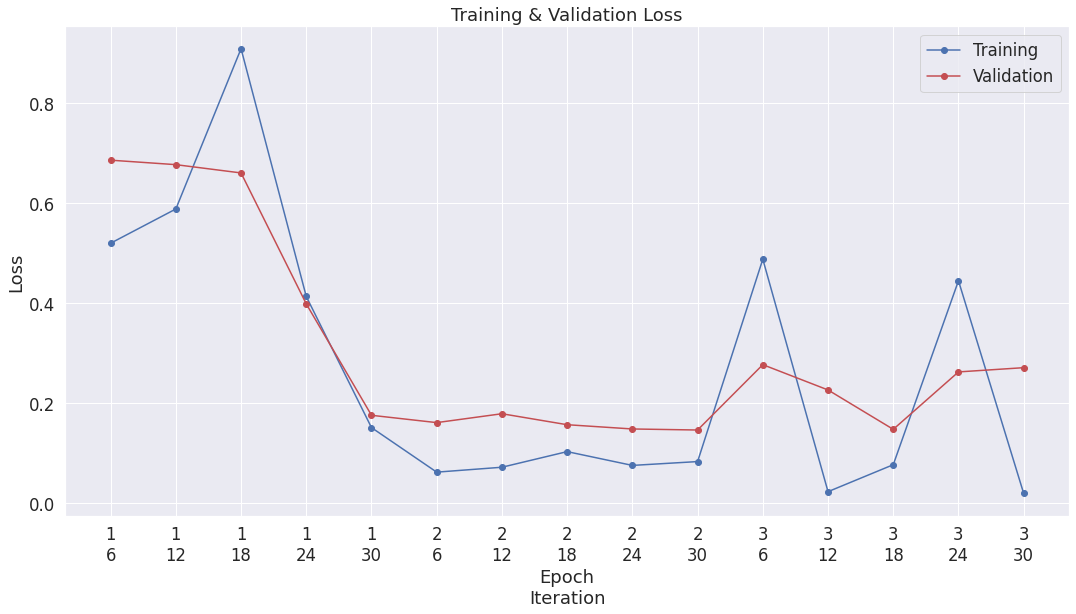

In [36]:
#For Learning curve 
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# polt, font 크기 키우기
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (18,9)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid Loss'], 'r-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch\nIteration")
plt.ylabel("Loss")

# "epoch-iteration" 형식으로 x축 라벨 만들기
epoch_iter = list(zip(list(df_stats['epoch']),list(df_stats['iteration'])))
plt.xticks(ticks = range(0,len(df_stats['iteration']+1)),labels = [str(epoch_iter_label[0])+"\n"+str(epoch_iter_label[1]) for epoch_iter_label in epoch_iter])

#plot 저장
#plt.savefig('Training_Validation_Loss.png')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [ ]:
test_dataset = test_df['Id']

In [ ]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [ ]:
test = make_id_file_test(tokenizer, test_dataset)

In [ ]:
test[:10]

In [ ]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [ ]:
test_dataset = SentimentTestDataset(tokenizer, test)

In [ ]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    #sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    sorted_indices = list(i for i in range(len(input_ids)))

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [ ]:
test_batch_size = 32
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size,
                                          shuffle=False, collate_fn=collate_fn_style_test,
                                          num_workers=2)

In [ ]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(test_loader,
                                                                        desc='Test',
                                                                        position=1,
                                                                        leave=None):

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        output = model(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids,
                       position_ids=position_ids)

        logits = output.logits
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions

In [ ]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission.csv', index=False)